# LRP

**LRP** (*layer-wise relevance propagation*) je tehnika (skup pravila) koja nam omugacava da za klasifikovanu instancu (u nasem slucaju tekst) odredimo koji atributi (reci) su u kojoj meri doprineli toj klasifikaciji.

Zasniva se na dodeljivanju  ***ocena relevantnosti*** (**doprinosa**) komponentama modela - od izlaza do ulaza.


Posebno je zanimljivo ovakve metode prilagoditi nelinearnim modelima npr. neuronskim mrezama. <br>
Kod neuronskih mreza svaki neuron imace svoju ocenu relevantnosti. <br>
Ocene ce se propagirati od izlaza sve do ulaza, prateci *zakon odrzanja* - svaki sloj sumu relevantnosti svojih neurona predaje sloju ispod (sloju blizem ulazu).

Zakon odrzanja relevantnosti moze se opisati sledecom formulom: 

<img src= ".\images\LRP_conservation.png" width ="200" heigth="10"></img>

gde *k* i *j* predstavljaju neurone susednih slojeva.

<img src=".\images\LRP_img.png"></img>

Dalje navodimo pravila racunanja relevantnosti neurona na osnovu relevantnosti neurona sloja iznad.

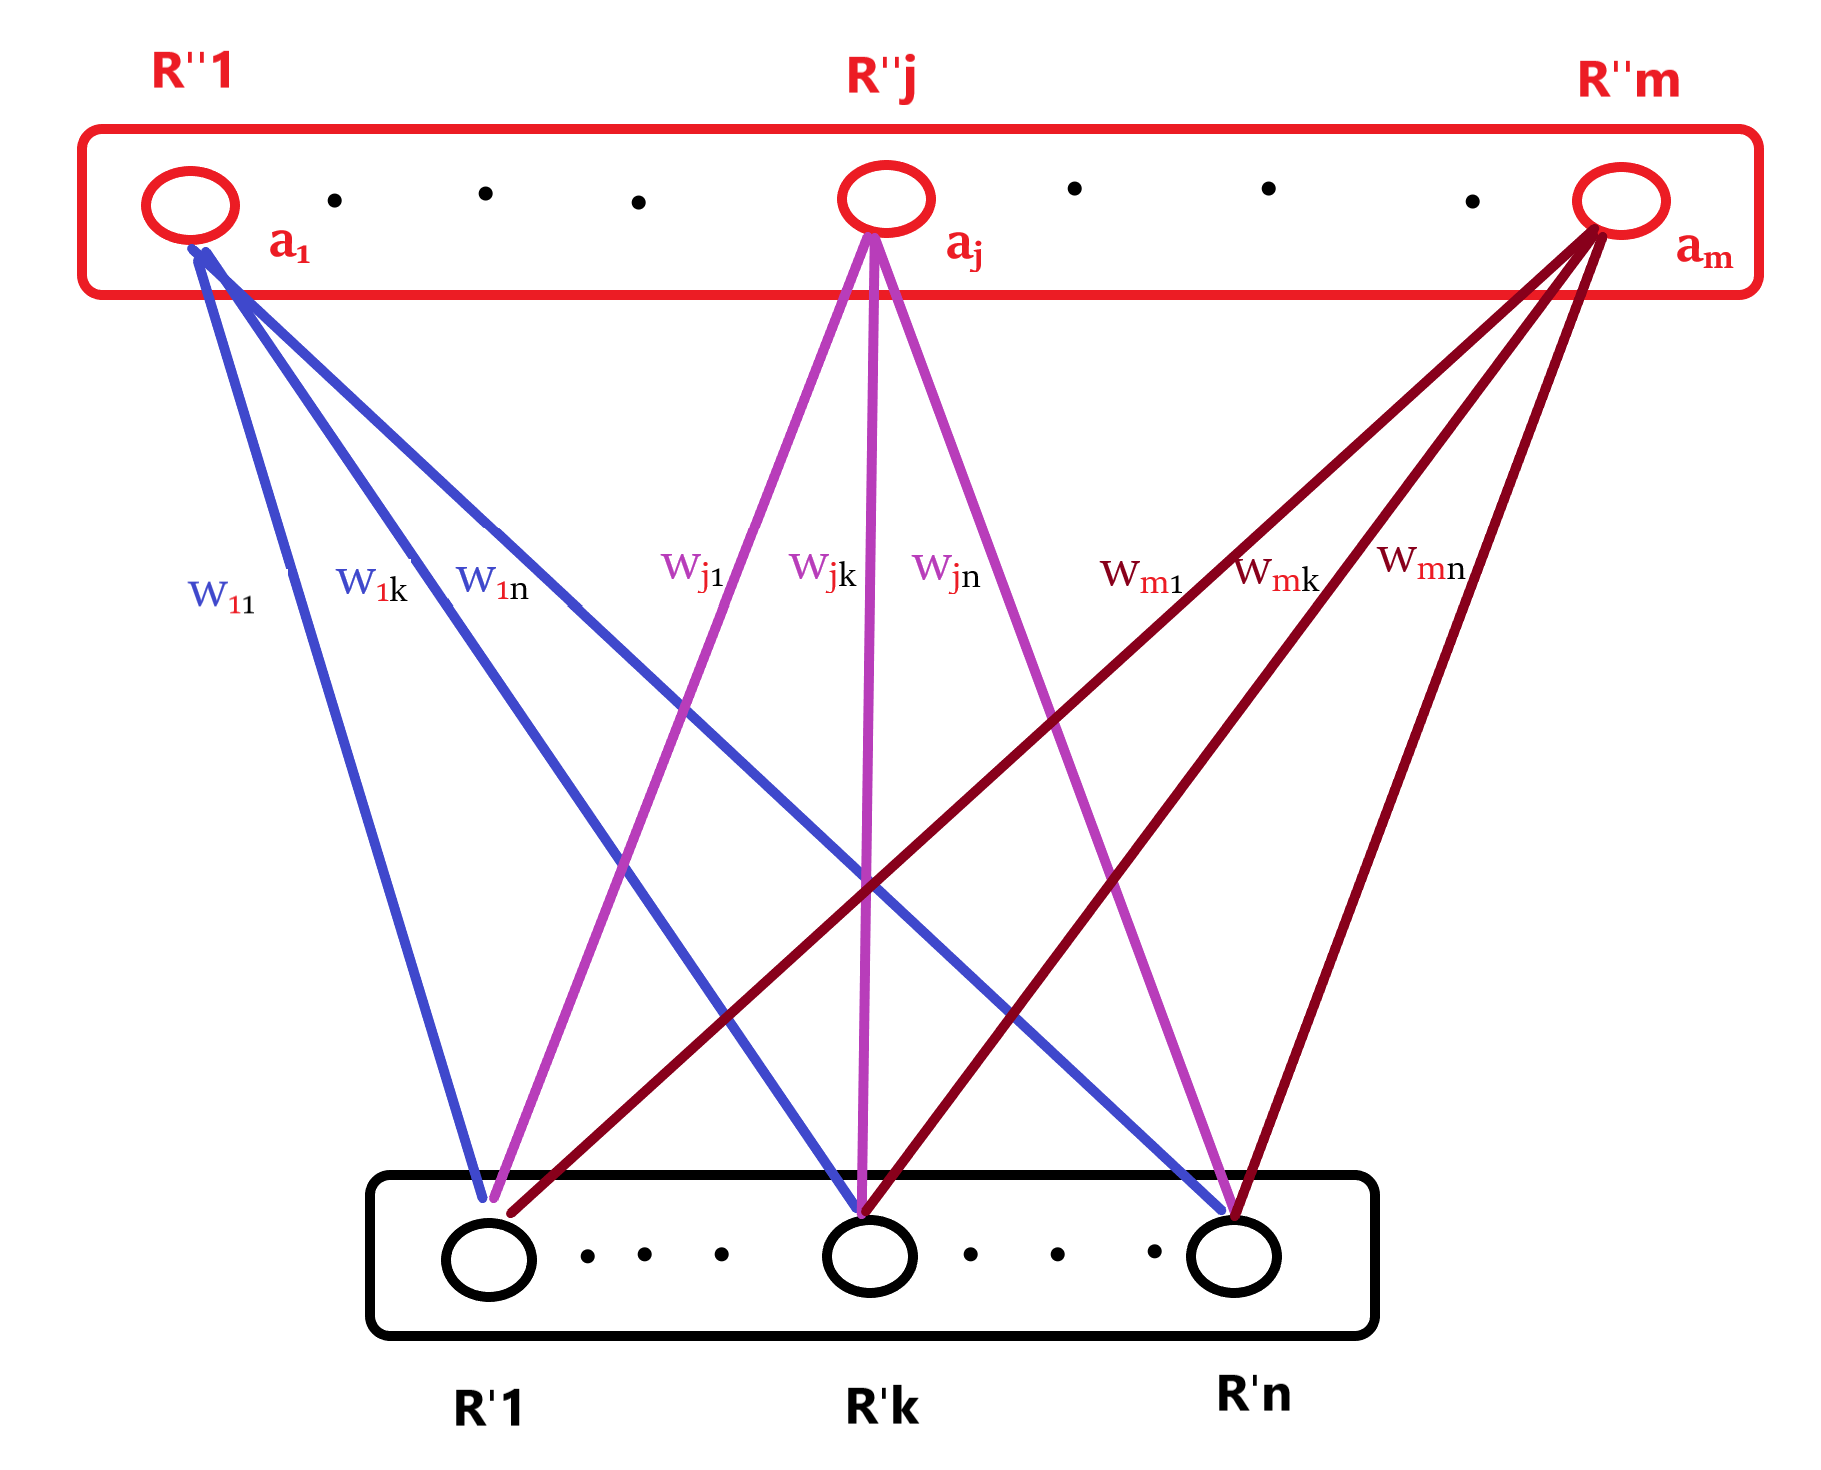

### Osnovno pravilo (*LRP-0*):

<img src=".\images\LRP_0.png" width="280" height="20"></img>

### ε - pravilo (*LRP-ε*):

<img src=".\images\LRP_eps.png" width="300" height="20"></img>

### γ - pravilo (*LRP-γ*):

<img src=".\images\LRP_gamma.png" width="330" height="20"></img>

### Generalno pravilo:

<img src=".\images\LRP_general.png" width="300" height="20"></img>

- ***a<sub>j</sub>*** predstavlja vrednost aktivacije *j*-tog neurona
- ***w<sub>jk</sub>*** tezinu koja spaja neuron *j* i neuron *k*
- ***ε*** je konstanta koja sprecava deljenje malim brojem, a takodje utice i na eliminaciju slabih doprinosa
- ***γ*** je konstanta kojom favorizujemo pozitivne doprinose
- ***ρ*** je uopstenje transformacije tezina (moze se eksperimentisati)

Preporuke za koriscenje ovih pravila po slojevima: 

<img src=".\images\LRP_layers.png"></img>

---

## Nas CNN model

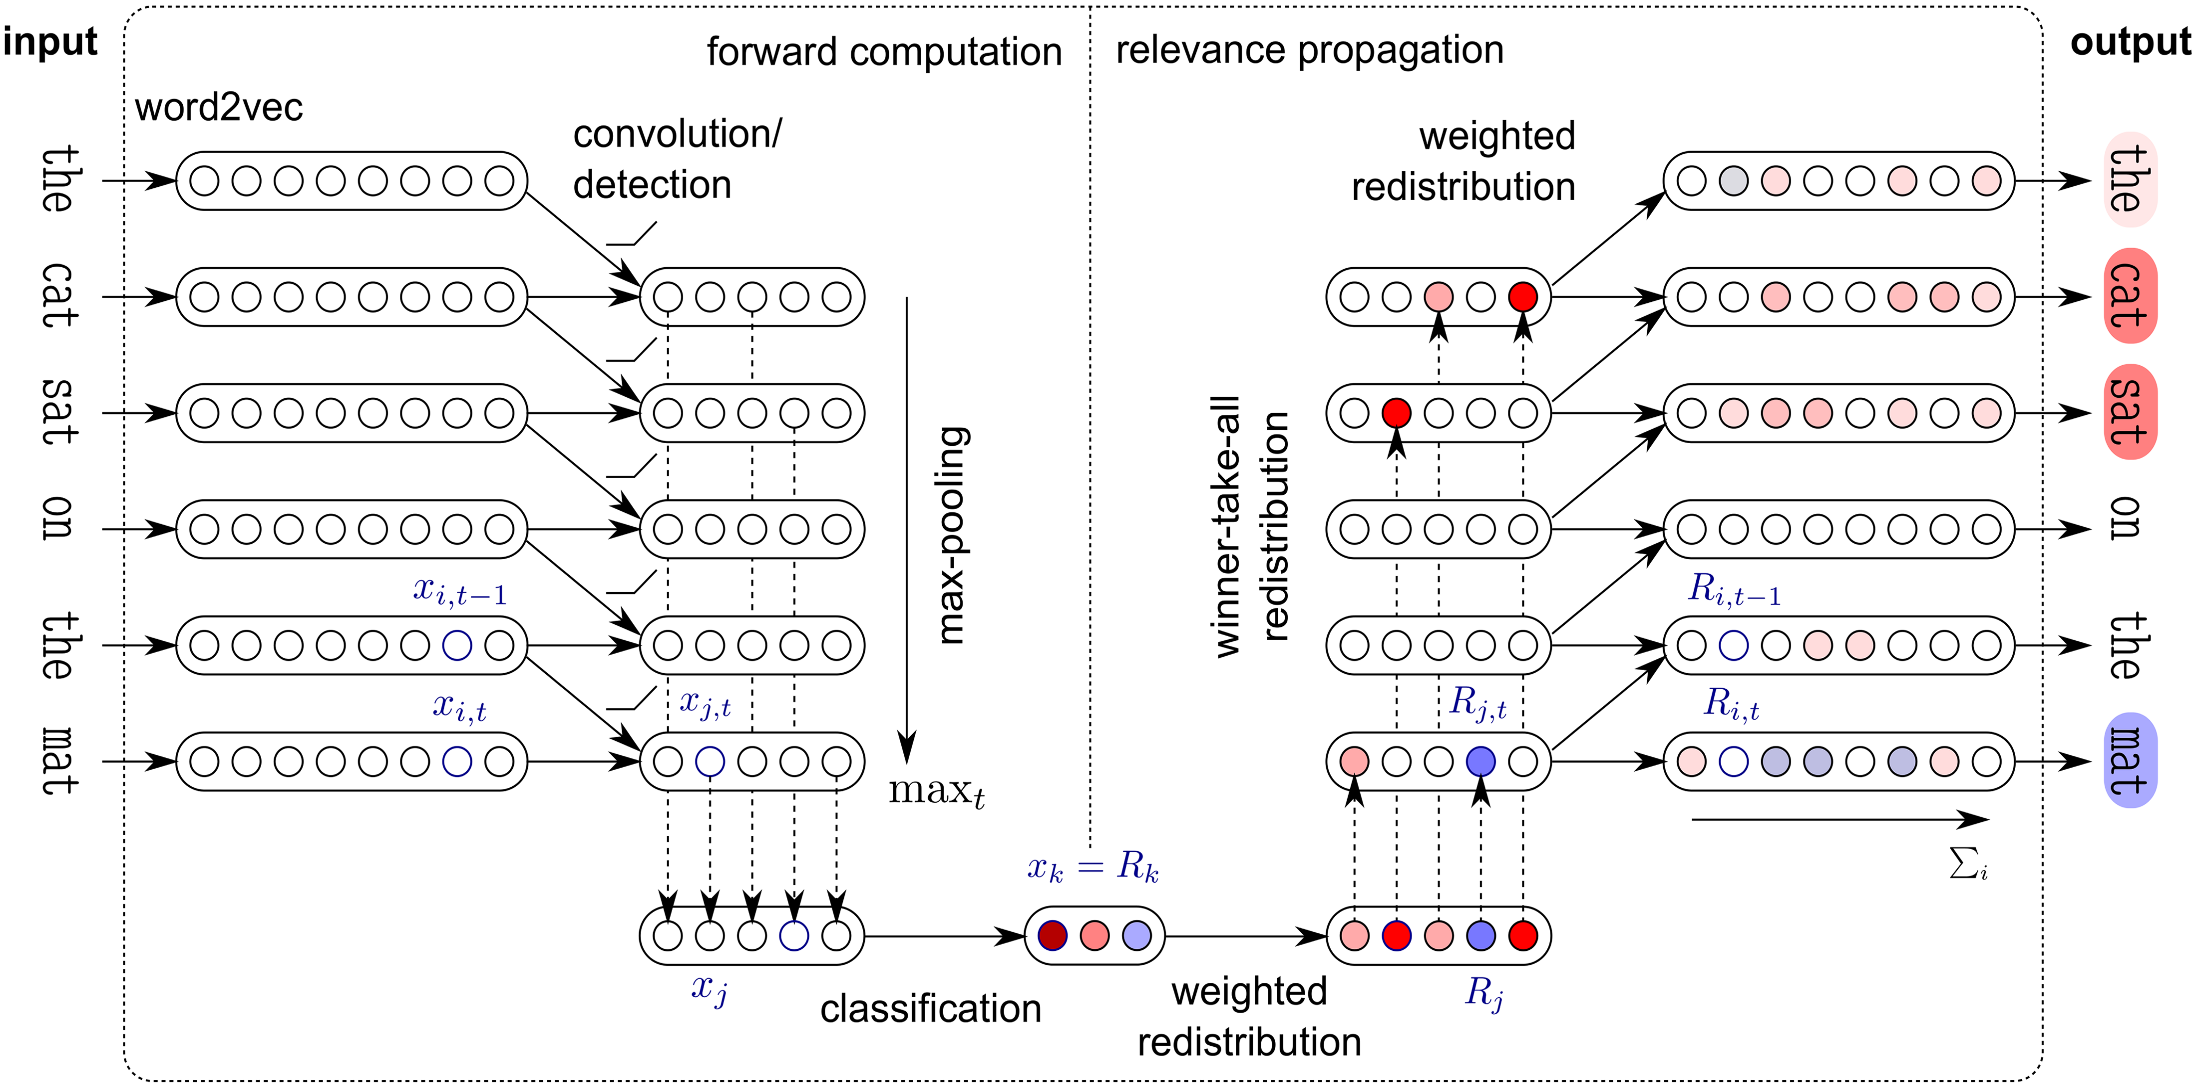

### *GlobalMaxPool* pravilo:

Kod ditribucije relevantnosti u ***GlobalMaxPool*** sloju koristimo *winner-take-all* strategiju odn.
neuron koji je imao najvecu aktivaciju (posle ***Conv*** sloja i ***Relu*** aktivacije) dobice celokupnu ocenu relevantnosti neurona iz sloja iznad (na slici - sloja ispod).

4 koraka za racunanje LRP:

<img src=".\images\LRP_4_steps.png"></img>

In [2]:
import numpy as np

In [3]:
def relprop(w, a, Rk, eps=0.01, rho=lambda x: x):
    # GORNJI SLOJ (onaj cije R imamo, koji predaje dalje)
    # DONJI SLOJ (onaj cije R racunamo)
    # w - tezine (wjk - j donji sloj, k gornji sloj ) - dim=(m,n)
    # a - aktivacije donjeg sloja - dim=(m)
    # R - relevantnosti gornjeg sloja - dim=(n) 
    
    n = len(Rk)    
    m = len(a)
    
    z = np.array([eps + np.dot(a, rho(w[:,k])) for k in range(n)])
    s = np.array([Rk[k] / z[k] for k in range(n)])
    c = np.array([np.dot(rho(w[j]),s) for j in range(m)])
    Rj = np.array([a[j]*c[j] for j in range(m)])
    
    return Rj

Mi cemo koristiti modifikovanu verziju:

<img src=".\images\lrp_dense.png"></img>
<img src=".\images\lrp_dense2.png"></img>
<img src=".\images\lrp_dense3.png"></img>



In [4]:
def relprop_dense(wb, aj, ak, F, Rk, eps=0.01, rho=lambda x: x):
    # GORNJI SLOJ (onaj cije R imamo, koji predaje dalje)
    # DONJI SLOJ (onaj cije R racunamo)
    # w - tezine (w0jk - j donji sloj, k gornji sloj ), w1j su bias (b) - dim=(2,m,n) 
    # aj - aktivacije donjeg sloja (na slici gore - xj)- dim=(m)
    # ak - aktivacije gornjeg sloja (na slici gore - xk)
    # R - relevantnosti gornjeg sloja - dim=(n) 
    # F - sirina filtera
    
    w = wb[0]
    b = wb[1]
    
    n = len(Rk)    
    m = len(aj)
    
    zjk = np.array([[ aj[j]*w[j][k] + (1/F)*(b[k] + eps*np.sign(ak[k])) for k in range(n)] for j in range(m)])
    
    R = [np.sum(np.array([zjk[j][k]/np.sum(zjk[:, k])*Rk[k] for k in range(n)]))  for j in range(m)]
    
    return R
    


In [5]:
def relprop_maxpool(X, Rj):
    #winner-take-all
    
    Rm = np.zeros(X.shape)
    for i in range(X.shape[1]):
        winner = np.argmax(X[:,i])
        Rm[winner][i] = Rj[i]
        
    return Rm

Propagacija R izmedju ***Conv*** i ***Embedding*** sloja (poslednja propagacija):

<img src=".\images\lrp_conv1.png"></img>
<img src=".\images\lrp_conv2.png"></img>
<img src=".\images\lrp_conv3.png"></img>

In [34]:
# Pravilo za konvoluciju adaptirano iz formule gore
# Formulu gore je tesko implementirati, u implementaciji dole sumu koja deli Rjt uprostili smo
# (kao kod konvolucije - mozemo jos dodati epsilon

def relprop_convolution2(xit, xjt, wb, window_size, F, H, D, Rjt, eps=0.01):
     #x je word2vec
     #wb je tenzor tezina konvolucije (i bias-a)
     #F broj filtera
     #H je maksimalna duzina dokumenta
     #D je velicina word2vec vektora
     #Rjt su prethodne relevantnosti
    
    #TAU_RANGE = H - window_size + 1
    tau = window_size
    
    xit = np.transpose(xit)
    xjt = np.transpose(xjt)
    Rjt = np.transpose(Rjt)
    
    
    w = wb[0]
    b = wb[1] 
    
    Rit = np.zeros((D, H))
    
    hd = 1/(H*D)
    
    zijt = np.zeros((D, F, H))
    
    zero_words = np.array([np.count_nonzero(xit[:,t]) for t in range(H)])
    
    # POTREBNO PUNO ODSECANJA (if - continueo)
    # nacelno se jako dugo izvrsava, 4tvorostruka petlja, slozene operacije nad visedimenzionim nizovima...
    # trebalo bi da se izvrsi za nekoliko sekundi do nekoliko desetina sekundi sa ovim modifikacijama
    
    # koliko ukupno Rjt predaje
    rjt_sum = np.zeros((F,H-tau))
    
    
    
    for j in range(F):
        #print(j)
        for t in range(H-tau):
            #print(j, t)
            rjt_sum[j][t] = (w[:,:,j].transpose()*xit[:, t:t+tau]).sum() + b[j] 
            
                    

    for s in range(tau):
        for t in range(H-tau+s):
            #print(t)
            if(zero_words[t]==0):
                continue
            for j in range(F):
                if Rjt[j][t-s] == 0:
                    continue
                for i in range(D):
                    Rit[i][t] += (xit[i][t]*w[s][i][j] + hd*(b[j] + eps*np.sign(xjt[j][t-s])))/(rjt_sum[j][t-s] + eps*np.sign(xjt[j][t]))*Rjt[j][t-s]
                
                    
    
                    
    return Rit
            
    
    
    

In [1]:
# def relprop_convolution(xit, xjt, wb, window_size, F, H, D, Rjt, eps=0.01):
#      #x je word2vec
#      #wb je tenzor tezina konvolucije (i bias-a)
#      #F broj filtera
#      #H je maksimalna duzina dokumenta
#      #D je velicina word2vec vektora
#      #Rjt su prethodne relevantnosti
    
#     T#AU_RANGE = H - window_size + 1
#     tau = window_size
    
#     xit = np.transpose(xit)
#     xjt = np.transpose(xjt)
#     Rjt = np.transpose(Rjt)
    
    
#     w = wb[0]
#     b = wb[1] 
    
#     Rit = np.zeros((D, H))
    
#     hd = 1/(H*D)
    
#     zijt = np.zeros((D, F, H))
    
#     zero_words = np.array([np.count_nonzero(xit[:,t]) for t in range(H)])
    
#      #POTREBNO PUNO ODSECANJA (if - continueo)
#      #nacelno se jako dugo izvrsava, 4tvorostruka petlja, slozene operacije nad visedimenzionim nizovima...
#      #trebalo bi da se izvrsi za nekoliko sekundi do nekoliko desetina sekundi sa ovim modifikacijama
    
#     for s in range(tau):
#         for t in range(H-tau+s):
#             if zero_words[t] == 0:
#                 continue
#             for j in range(F):
#                 if Rjt[j][t-s] == 0:
#                     continue
#                 for i in range(D):
#                     zijt[i][j][t] += xit[i][t]*w[s][i][j] + hd*(b[j] + eps*np.sign(xjt[j][t-s]))
                    
#     zt = [np.sum(zijt[:,:,t]) for t in range(H)]
    
#     for s in range(tau):
#         for t in range(H-tau+s):
#             if zero_words[t] == 0:
#                 continue
#             for j in range(F): 
#                 if Rjt[j][t-s] == 0:
#                     continue
#                 for i in range(D):
#                     Rit[i][t] += (xit[i][t]*w[s][i][j] + hd*(b[j] + eps*np.sign(xjt[j][t-s])))/zt[t]*Rjt[j][t]

                    
#     return Rit
            
    
    
    

In [13]:
# Konacni LRP koji propagira R od vrha mreze (izlaza) do dna (ulaza) 
# koristeci ranije implementirane funkcije

def LRP(model, inp, cat, eps=0.01):
    F = model.layers[2].output_shape[2]
    H = model.input_shape[1]
    D = model.layers[0].output_shape[2]
    
    
    window_size = H - model.layers[2].output_shape[1] + 1
    
    print(window_size)
    
    wb_conv_to_emb = model.layers[2].get_weights()
    wb_dense_to_end = model.layers[-1].get_weights()
    activation_conv = backend.function([model.layers[0].input], [model.layers[2].output])
    activation_dense = backend.function([model.layers[0].input], [model.layers[3].output])
    activation_end = backend.function([model.layers[0].input], [model.layers[-1].output])
    
    Rk = np.zeros(20)
    Rk[cat] = activation_end(inp)[0][0][cat]
    
    Rj = relprop_dense(wb_dense_to_end, activation_dense(inp)[0][0], activation_end(inp)[0][0], F, Rk, eps=eps)
    
    Rp = relprop_maxpool(activation_conv(inp)[0][0], Rj)
    
    Ri = relprop_convolution2(model.layers[0].get_weights()[0][inp][0], activation_conv(inp)[0][0], wb_conv_to_emb, window_size=window_size, F=F, H=H, D=D, Rjt=Rp, eps=eps)
    
    return Ri

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Conv1D, Embedding, Dropout, MaxPool1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
from sklearn import datasets

In [17]:
import os

In [18]:
import pickle

In [19]:
import gensim

In [20]:
from matplotlib import pyplot as plt

In [21]:
import matplotlib

In [167]:
#X_test[100] zanimljiv

### Ucitavanje i priprema podataka

In [22]:
max_doc_len = 400

In [23]:
model = load_model(os.path.join("models", "test_model.hdf5"))

In [24]:
model_emb = load_model(os.path.join("models", "test_model_emb.hdf5"))

In [25]:
with open(os.path.join("models", "vectorizer.pickle"), "rb") as load_file:
    vectorizer = pickle.load(load_file)

In [26]:
cbow_model_full = gensim.models.word2vec.Word2Vec.load(os.path.join("models", "cbow.wv"))
cbow = cbow_model_full.wv

In [27]:
cbow_vocab_plus1 = { word : cbow.key_to_index[word] + 1 for word in cbow.key_to_index}
cbow_key_to_index = cbow_vocab_plus1
cbow_index_to_key = { cbow_key_to_index[word] : word for word in cbow_key_to_index }

In [28]:
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
X_test = test_data.data
y_test = test_data.target
feature_names = test_data.target_names

In [29]:
def prepare_input(text):
    text = vectorizer.tokenizer(text)
    text_idx = np.array([cbow_key_to_index[word] for word in text if word in cbow_key_to_index ])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

In [30]:
def prepare_input_with0(text):
    text = vectorizer.tokenizer(text)
    text_idx = np.array([cbow_key_to_index[word] if word in cbow_key_to_index else 0 for word in text])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

In [31]:
def plot_relevance(R, words, num_rows=10):
    Rtoplot = R.reshape(40, 10)[-num_rows:]
    wtoplot = words.reshape(40,10)[-num_rows:]
    
    plt.figure(figsize=(16,16))

    im = plt.imshow(Rtoplot[-num_rows:])

    plt.xticks([])
    plt.yticks([])

    plt.colorbar()

    anot = wtoplot[-num_rows:]
    for i in range(anot.shape[0]):
        for j in range(anot.shape[1]):
            im.axes.text(j, i, anot[i, j], ha='center')
    
    
    

In [38]:
def show_relevance(text, model, epsilon=0.01):
    if len(text) < 1000:
        print(text)
        
    # pripremamo tekst (prebacujemo ga u indeksnu reprezentaciju - rec u indeks)
    text_input = prepare_input_with0(text)
    
    prediction = model.predict([text_input])[0]
    # predvidjamo kategoriju
    cat = np.argmax(prediction)
    # koliko je model siguran
    certainty = prediction.max()
    
    print("Predicted category: ", feature_names[cat])
    print("with certainty of: ", certainty)
    
    # odredjujemo inicijalne relevantnosti (rasporedjene po vektorima reci)
    R = LRP(model, text_input, cat, epsilon)
    
    # sumiramo ih da dobijemo relevantnost svake reci
    relevances = R.transpose().sum(axis=1)
    
    # skaliramo relevantnosti
    
    relevances_scaled = relevances#(relevances - relevances.mean())/relevances.std()
    
    # sortiramo reci po relevantnosti
    rel_sorted = np.argsort(relevances_scaled)
    
    # prebacimo tekst u listu reci
    words = np.array([cbow_index_to_key[index] if index > 0 else "*" for index in text_input[0]])
    
    # ispisemo po 5 najuticajnih reci (5 pozitivnih i 5 negativnih)
    print("5 most posive words: ")
    for i in range(1,6):
        print(f"[{words[rel_sorted][-i]}]", " with score: ", relevances_scaled[rel_sorted[-i]])
        
    print("5 most negative words: ")
    for i in range(5):
        print(f"[{words[rel_sorted][i]}]", " with score: ", relevances_scaled[rel_sorted[i]])
        
    # iscrtamo heatmap-u poslednjih 10*num_rows reci teksta (poslednjih zbog prepadding-a)
    
    
    plot_relevance(relevances_scaled, words, num_rows=20)
    

Does anybody have a data-sheet handly for the above-mentioned card?  I
bought one, sans manual at a local surplus shop, and want to try it out
with the Crywyr packet driver suite.  

The IRQ and interface-select jumpers are pretty straightforward, but I
don't grok the settings of W10-W18 (also labelled A15 through A18).
Could somebody tell me which settings of these four jumpers correspond
to what I/O addresses?

Is there anything else about this card I should know, before I
plug&play?

-- 
Dave Platt                                                VOICE: (415) 813-8917
              Domain: dplatt@ntg.com      UUCP: ...netcomsv!ntg!dplatt
 USNAIL: New Technologies Group Inc. 2470 Embarcardero Way, Palo Alto CA 94303

1/1 [==============================] - 0s 17ms/step
Predicted category:  comp.sys.ibm.pc.hardware
with certainty of:  0.5520901
2
5 most posive words: 
[card]  with score:  0.3456405917185237
[card]  with score:  0.17827606416285707
[Inc.]  with score:  0.09935899143150263

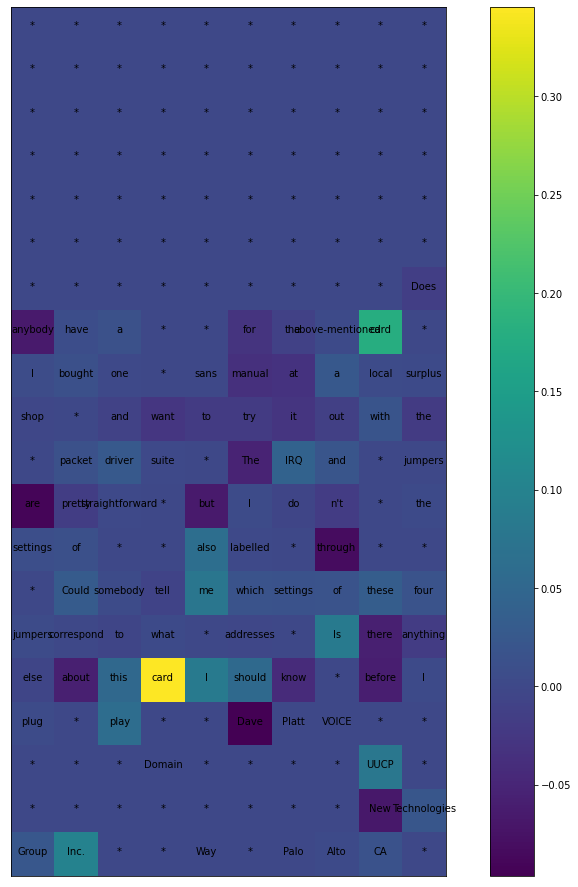

In [40]:
show_relevance(X_test[53], model)

1/1 [==============================] - 0s 29ms/step
Predicted category:  rec.sport.hockey
with certainty of:  0.9106415
2
5 most posive words: 
[team]  with score:  0.365898086818727
[game]  with score:  0.26481228440578103
[team]  with score:  0.18984272999674054
[team]  with score:  0.1482739652975225
[had]  with score:  0.11922547472017793
5 most negative words: 
[than]  with score:  -0.13198702430693593
[we]  with score:  -0.10573110347840992
[up]  with score:  -0.09136353021895703
[all]  with score:  -0.08949110033224221
[like]  with score:  -0.0857991970248943


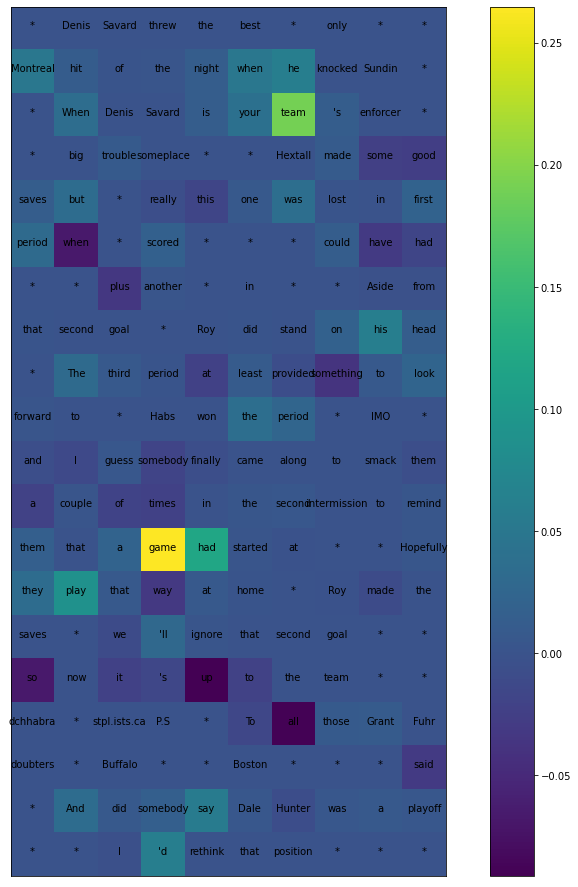

In [43]:
show_relevance(X_test[17], model)

1/1 [==============================] - 0s 14ms/step
Predicted category:  talk.politics.mideast
with certainty of:  0.43590704
2
5 most posive words: 
[Armenian]  with score:  0.32905258105890217
[Armenia]  with score:  0.2463913993958164
[Turkish]  with score:  0.20571857555186043
[Turkish]  with score:  0.20009349170466184
[has]  with score:  0.14049971559437652
5 most negative words: 
[price]  with score:  -0.16658077426191867
[than]  with score:  -0.1294817238346005
[The]  with score:  -0.08116663320282153
[University]  with score:  -0.08081541000312567
[over]  with score:  -0.07779741284766603


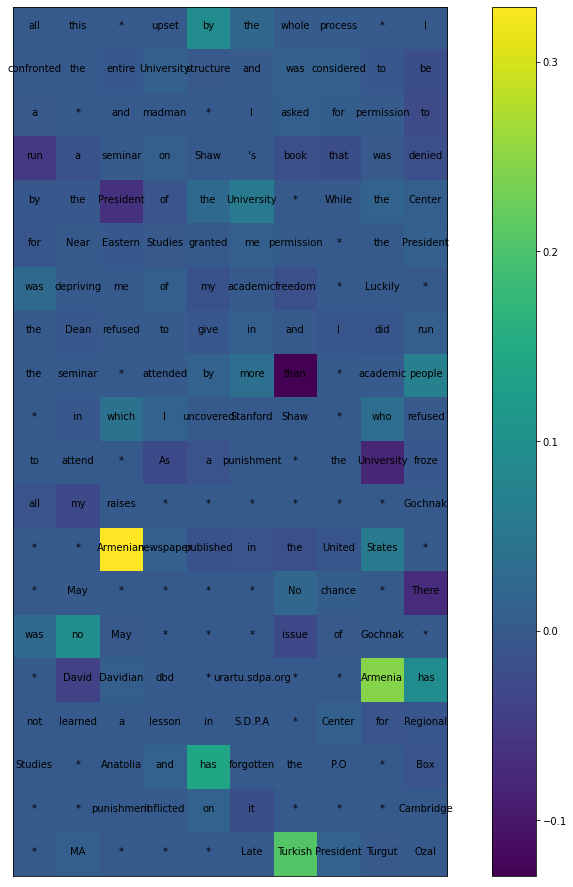

In [45]:
show_relevance(X_test[503], model)

1/1 [==============================] - 0s 17ms/step
Predicted category:  sci.crypt
with certainty of:  0.9654434
2
5 most posive words: 
[government]  with score:  0.39579877036529726
[other]  with score:  0.13381002089285965
[It]  with score:  0.10962073959428108
[Computer]  with score:  0.09565247769864477
[when]  with score:  0.08953683770667932
5 most negative words: 
[which]  with score:  -0.10876910170567107
[Jeff]  with score:  -0.08279525767143799
[in]  with score:  -0.07909520135819312
[any]  with score:  -0.0778328211300457
[includes]  with score:  -0.06350872273013847


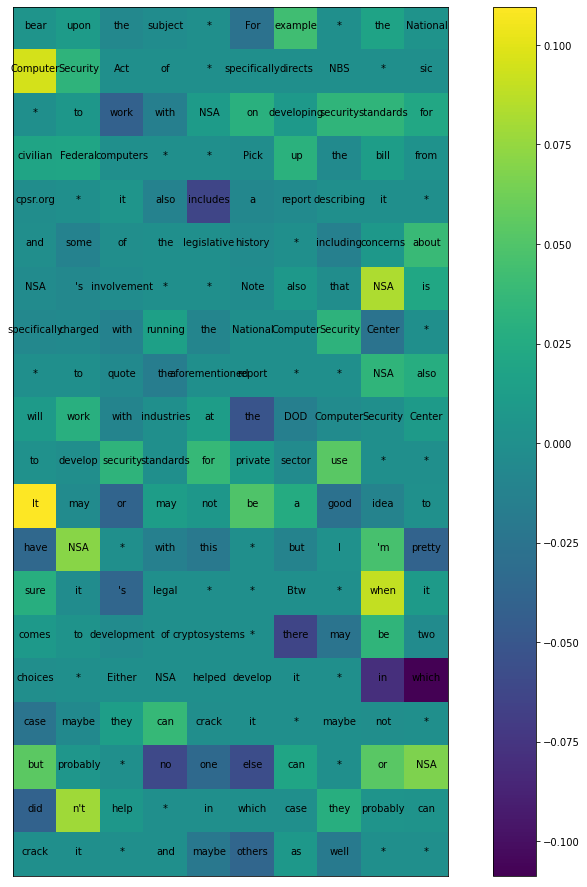

In [46]:
show_relevance(X_test[100], model)

In [48]:
# primecujemo veliki uticaj stop reci...

In [49]:
# po svemu sudeci, SVM je za sad bolji

In [50]:
# moguci problemi:
#    1. Los embeding (koristiti google-ov - velicine oko 3GB, oko 3 miliona reci)
#    2. Lose istrenirana mreza (losa arhitektura - popraviti)
#    3. Skup podataka siromasan
#    4. Stop reci (izbaciti i probati)
#    5. Sama LRP metoda (proveriti greske, isprobati epsilon, ...)